# GAN

#### Load dependencies

In [1]:
import numpy as np
import os

import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D
from tensorflow.keras.optimizers import RMSprop

import pandas as pd
from matplotlib import pyplot as plt
np.set_printoptions(suppress=True)

#### Load data

In [2]:
input_images = "quickdraw_data/apple.npy"

In [3]:
data = np.load(input_images)

In [4]:
data.shape

(144722, 784)

In [5]:
data = data/255
data = np.reshape(data, (data.shape[0], 28,28,1))
img_w, img_h = data.shape[1:3]
data.shape

(144722, 28, 28, 1)

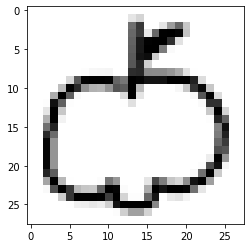

In [6]:
plt.imshow(data[4343,:,:,0], cmap='Greys')

In [7]:
def discriminator_builder(width=64,p=0.4):
    
    # define inputs:
    inputs = Input((img_w, img_h, 1))
    
    # convolutional layers
    conv1 = Conv2D(width*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(width*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(width*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(width*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))

    # output layer
    output = Dense(1, activation='sigmoid')(conv4)
    
    # model definition
    
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model    

In [8]:
discriminator = discriminator_builder()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 256)        

In [9]:
discriminator.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0008, decay=6e-8, clipvalue=1.0), metrics=['accuracy'])

#### Create generator network

In [16]:
def generator_builder(z_dim=100, width=64, p=0.4):
    
    # define inputs
    inputs = Input((z_dim,))
    
    # first dense layer
    dense1 = Dense(7*7*64)(inputs)
    dense1 = BatchNormalization(momentum=0.9)(dense1)
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,64))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # deconvolutional layer
    
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(width/2), kernel_size=5, padding='same', activation=None)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
  
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(width/4), kernel_size=5, padding='same', activation=None)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(width/8), kernel_size=5, padding='same', activation=None)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3) 
    
    # output layer
    output = Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)
    
    # define model
    
    model = Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model   

In [17]:
generator = generator_builder()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_5 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_5 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 64)       

####  Create adversarial network

In [19]:
def adversarial_builder(z_dim=100):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.00004,decay=3e-8, clipvalue=1.0),
                  metrics=['accuracy'])
    model.summary()
    return model

In [20]:
adversarial_model = adversarial_builder()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_5 (Functional)    (None, 28, 28, 1)         396961    
_________________________________________________________________
functional_1 (Functional)    (None, 1)                 4311553   
Total params: 4,708,514
Trainable params: 4,702,130
Non-trainable params: 6,384
_________________________________________________________________


#### Train

In [21]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [22]:
def train(epochs=2000, batch=128):
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        if i%100 == 0:
            print(i)
        real_imgs = np.reshape(data[np.randpm.choice(data.shape[0], batch, replace=False)], (batch(28,28,1)))
        fake_imgs = generator.predict(np.random.uniform(-1.0,1.0, size=[batch, 100]))
        
        x = np.concatenate((real_imgs, fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        make_trainable(discriminator, True)
        
        d_meterics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_meterics[-1][1]
        
        make_trainable(discriminator, False)
        
        noise = np.random.uniform(-1.0,1.0, size=[batch, 100])
        y = np.ones([batch,1])
  
        a_meterics.append(adversarial_model.train_on_batch(noise,y))
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_meterics[-1][1]
        
        if (i+1)%100 == 0:

            print('Epoch #{}'.format(i))
            log_mesg = "%d: [D loss: %f, acc: %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % \
            (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, 
                                      size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], 
                           cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

In [ ]:
a_metrics_complete, d_metrics_complete = train()